# In-Depth Gaussian Mixture Models (GMM) — A Notebook-Style Walk-through

---

##  Intuition & Theory (Compact but Precise)

### What is a GMM?
A **Gaussian Mixture Model** represents the probability density of data as a weighted sum of $K$ Gaussian components:

$$p(\mathbf{x}) = \sum_{k=1}^{K} \pi_k \mathcal{N}(\mathbf{x} \mid \boldsymbol{\mu}_k, \boldsymbol{\Sigma}_k)$$

Where:
* $\pi_k$: **Mixing weights** (non-negative, sum to 1).
* $\boldsymbol{\mu}_k$: **Means** for each component.
* $\boldsymbol{\Sigma}_k$: **Covariances** defining the shape of each component.

### Why use GMMs?
* **Soft Clustering:** Unlike K-Means, each point has a "responsibility" (probability) across all components.
* **Density Estimation:** Models multi-modal continuous data effectively.
* **Flexibility:** Can capture elliptical clusters with varying orientations (depending on covariance type).

---

## How do we fit it? — Expectation-Maximization (EM)

Given data $\{x_n\}_{n=1}^N$ and $K$ components, we maximize the log-likelihood iteratively:

### E-step: Compute Responsibilities
Calculate the posterior probability that point $x_n$ was generated by component $k$:
$$\gamma_{nk} = \frac{\pi_k \mathcal{N}(x_n \mid \mu_k, \Sigma_k)}{\sum_{j=1}^K \pi_j \mathcal{N}(x_n \mid \mu_j, \Sigma_j)}$$

### M-step: Update Parameters
Update the parameters using the responsibilities calculated in the E-step:

1.  **Effective number of points assigned to $k$:** $N_k = \sum_{n=1}^N \gamma_{nk}$
2.  **New Means:** $\mu_k = \frac{1}{N_k} \sum_{n=1}^N \gamma_{nk} x_n$
3.  **New Covariances:** $\Sigma_k = \frac{1}{N_k} \sum_{n=1}^N \gamma_{nk} (x_n - \mu_k)(x_n - \mu_k)^T$
4.  **New Mixing Weights:** $\pi_k = \frac{N_k}{N}$

> **Note:** Repeat these steps until the log-likelihood change is less than a tolerance (`tol`) or `max_iter` is reached.

---

## 3. Model Selection & Metrics

### Selection Metrics
* **Log-likelihood:** Measures how well the model fits the data (higher is better).
* **AIC / BIC:** Information criteria that penalize model complexity to prevent overfitting. These are commonly used to choose the optimal number of components $K$.
    $$\text{BIC} = -2\log L + p \log N$$
    *(where $p$ is the number of parameters and $N$ is the number of samples)*.

### Performance Metrics
If ground-truth labels exist, we can evaluate the model using:
* **ARI (Adjusted Rand Index)** & **NMI (Normalized Mutual Information)**.
* **Accuracy:** Calculated after performing best-matching between cluster IDs and true labels.
* **Silhouette Score:** Useful for measuring cluster separation, though it favors certain geometries.

# Main scikit-learn API & Important Hyperparameters

To implement GMM in Python, we use the standard Scikit-Learn class:
`from sklearn.mixture import GaussianMixture`

---

### Key Parameters to Tune

* **`n_components` ($K$):** The number of Gaussians (clusters). This is the most critical parameter to tune.
* **`covariance_type`:** Defines the degree of freedom for the shape of the clusters.
    
| Type | Description |
| :--- | :--- |
| **`full`** | Each component has its own general covariance. Most flexible, but requires the most parameters. |
| **`diag`** | Each component has its own diagonal covariance. Useful for high-dimensional data. |
| **`spherical`** | Each component has its own single variance (circular clusters). |
| **`tied`** | All components share the same covariance matrix. |



* **`n_init`:** The number of initializations to perform. Since EM can get stuck in local optima, running it multiple times (e.g., 5–10) helps find the best global solution.
* **`init_params`:** The method used to initialize weights, means, and precisions.
    * `'kmeans'` (Default): Usually provides a strong starting point.
    * `'random'`: Randomly assigns initial values.
* **`reg_covar`:** Non-negative regularization added to the diagonal of covariance matrices. This ensures the matrices are "positive definite" and prevents the model from crashing due to singular matrices.
* **`tol` & `max_iter`:** Convergence criteria. The EM algorithm stops when the log-likelihood improvement falls below `tol` or reaches `max_iter`.
* **`random_state`:** Ensures reproducibility of our results.

---

### Practical Defaults & Best Practices

For a robust starting point, consider these settings:
* **`n_init=10`**: To ensure stability.
* **`init_params='kmeans'`**: For efficient convergence.
* **`reg_covar=1e-6`**: Increase this (e.g., `1e-4`) if we encounter "singular matrix" errors.
* **`covariance_type='full'`**: Start here, then switch to `diag` if we have high-dimensional data or notice overfitting.

---

# Apply GMM to a scikit-learn dataset — Iris (step-by-step code)

ARI: 0.9038742317748124
Silhouette: 0.37416491866541235
Log-likelihood (avg/sample): -1.936926397383053
AIC: 669.0779192149159 BIC: 801.5458721551512


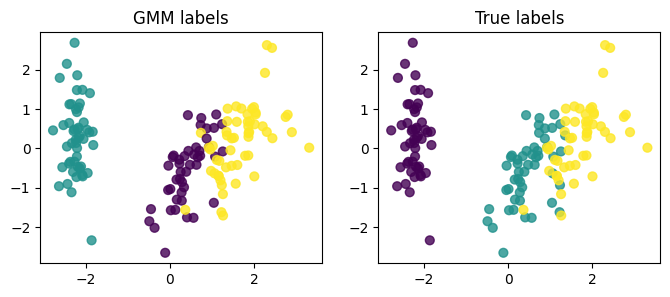

In [1]:
# 0. imports
import numpy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
from sklearn.metrics import adjusted_rand_score, silhouette_score


# 1. Load data
iris = datasets.load_iris()
X = iris.data
y_true = iris.target   # we only use this for evaluation

# 2. Scale (important)
scaler = StandardScaler()
Xs = scaler.fit_transform(X)

# 3. Fit GMM (we try K=3 because Iris has 3 species)
gmm = GaussianMixture(n_components=3, covariance_type='full',
                      n_init=10, init_params='kmeans', random_state=42)
gmm.fit(Xs)
labels = gmm.predict(Xs)           # hard assignment from responsibilities
probs = gmm.predict_proba(Xs)      # soft responsibilities
log_likelihood = gmm.score(Xs).sum()


# 4. Evaluate
ari = adjusted_rand_score(y_true, labels)
sil = silhouette_score(Xs, labels)
bic = gmm.bic(Xs)
aic = gmm.aic(Xs)

print("ARI:", ari)
print("Silhouette:", sil)
print("Log-likelihood (avg/sample):", gmm.score(Xs))
print("AIC:", aic, "BIC:", bic)


# 5. Visualize in 2D with PCA
pca = PCA(n_components=2)
X2 = pca.fit_transform(Xs)
plt.figure(figsize=(8,3))
plt.subplot(1,2,1)
plt.title("GMM labels")
plt.scatter(X2[:,0], X2[:,1], c=labels, s=40, cmap='viridis', alpha=0.8)
plt.subplot(1,2,2)
plt.title("True labels")
plt.scatter(X2[:,0], X2[:,1], c=y_true, s=40, cmap='viridis', alpha=0.8)
plt.show()


Notes on results:

We compare ARI and silhouette with k-means baselines. GMM can perform better when clusters have different covariances.

Check gmm.weights_, gmm.means_, gmm.covariances_ for learned params.

# Build a Pipeline + Hyperparameter Tuning (Wine Dataset)

In this section, we demonstrate how to integrate GMM into a professional machine learning workflow. We use the **Wine Dataset** to walk through a typical dimensionality reduction and clustering pipeline.

### The Pipeline Architecture
To ensure the model performs optimally, we chain the following steps:
1. **`StandardScaler`**: Scales features to have a mean of 0 and variance of 1 (essential for distance/density-based models).
2. **`PCA`**: Reduces noise and dimensionality, helping GMM focus on the most important components of the data.
3. **`GaussianMixture`**: The final clustering estimator.

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, StratifiedKFold
from sklearn.metrics import make_scorer, adjusted_rand_score
from sklearn.datasets import load_wine

# Load
data = load_wine()
Xw = data.data
yw = data.target

pipe = Pipeline([
    ('scaler', StandardScaler()),
    ('pca', PCA()),
    ('gmm', GaussianMixture(init_params='kmeans', n_init=5, random_state=0))
])

# Define scorer using ARI (we will use labels for validation)
ari_scorer = make_scorer(adjusted_rand_score)

# Grid for a reasonably small search
param_grid = {
    'pca__n_components': [2, 5, 8],
    'gmm__n_components': [2, 3, 4, 5],
    'gmm__covariance_type': ['full', 'diag'],
    'gmm__reg_covar': [1e-6, 1e-4]
}

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=0)

grid = GridSearchCV(pipe, param_grid, scoring=ari_scorer, cv=cv, n_jobs=-1)
grid.fit(Xw, yw)   # note: we pass yw only for scoring during CV, GMM.fit ignores y
print("Best params:", grid.best_params_)
print("Best CV ARI:", grid.best_score_)


Best params: {'gmm__covariance_type': 'full', 'gmm__n_components': 3, 'gmm__reg_covar': 1e-06, 'pca__n_components': 8}
Best CV ARI: 0.9830370101596516


Notes

We used supervised scoring to choose hyperparameters for demonstration. In purely unsupervised use, replace scoring with 'neg_log_loss' or use grid.best_estimator_.named_steps['gmm'].bic(X) to pick K by BIC after the grid search.

GaussianMixture.score(X) returns per-sample average log probability (useful for CV scoring when no labels).

# Bias–Variance Tradeoff & Model Selection

### Understanding the Tradeoff
Finding the right number of components ($K$) is a balancing act between underfitting and overfitting:

* **High Bias (Underfitting):** $K$ is too small. The model is too simple to capture the underlying multi-modality of the data.
* **High Variance (Overfitting):** $K$ is too large. The model becomes too flexible, fitting noise or creating tiny, spurious sub-clusters.
* **Covariance Complexity:** `full` covariance has lower bias but higher variance compared to `diag` or `spherical`.



### How to Manage the Tradeoff
1.  **Use BIC/AIC:** BIC is generally preferred as it carries a stronger penalty for additional parameters.
2.  **Cross-Validation:** Evaluate log-likelihood on held-out data.
3.  **Regularization:** Use `reg_covar` to prevent the model from collapsing into singular matrices.
4.  **Dimensionality Reduction:** Use PCA to reduce the feature space ($d$) before fitting, which significantly lowers variance.

---

# GMM Failure Modes & Mitigations

| Problem | Description | Mitigation |
| :--- | :--- | :--- |
| **Non-Gaussian Clusters** | Data lies on manifolds (rings, moons) or has heavy tails. | Use Spectral Clustering, DBSCAN, or feature transformations. |
| **High Dimensions** | Unstable covariance estimation and overfitting. | Use `diag` or `tied` covariance; apply PCA first. |
| **Outliers** | Gaussians are highly sensitive to extreme values. | Robust scaling, trimming outliers, or using Student's t-distributions. |
| **Local Optima** | EM converges to a sub-optimal local maximum. | Increase `n_init` (5-20) and use `init_params='kmeans'`. |
| **Singular Covariance** | A component "collapses" onto a single data point. | Increase `reg_covar` and monitor `gmm.weights_`. |

---

# Practical Checklist for Implementation

- **Standardize:** Always use `StandardScaler` before fitting.
- **Visualize:** Use PCA, t-SNE, or UMAP to inspect clusters in 2D/3D.
- **Initialize:** Set `n_init=10` to avoid bad local optima.
- **Tune K:** Use a BIC plot to find the "elbow" or minimum point.
- **Verify Components:** Check `gmm.weights_` to ensure no components have near-zero influence.
- **Validate:** If we have labels, use **ARI** or **NMI**; otherwise, use silhouette scores or BIC.

---

# Complexity & Interview "Cheat Sheet"

### Technical Complexity
* **Time Complexity:** Roughly $O(N \cdot K \cdot d^2)$ per iteration for `full` covariance. It scales linearly with $N$ (samples) and $K$ (components), but quadratically with $d$ (dimensions).
* **EM Algorithm:** A likelihood maximization strategy that alternates between E-steps (assigning responsibilities) and M-steps (updating parameters). It is guaranteed to never decrease likelihood but can get stuck in local maxima.

### Key Interview Comparisons
* **GMM vs. K-Means:** K-Means is a special, restricted case of GMM where covariances are equal/spherical and assignments are "hard" (0 or 1). GMM allows for "soft" probabilistic assignments and flexible cluster shapes.
* **Choosing K:** Explain that we use **BIC** because it penalizes complexity more strictly than AIC, helping to prevent overfitting in unsupervised tasks.

---

# When to Choose GMM
* When we need **uncertainty estimates** (soft clustering).
* When clusters are **not spherical** (e.g., elongated ellipses).
* When we need a **generative model** to sample new, synthetic data points.
* When modeling **multi-modal** behaviors (perfect for our **event management project** to identify diverse guest personas).